# Logistic regression

# Dataset:
German Credit

# Objective
Estimate default probabilities using logistic regression

# 1. Load Libraries and data

In [46]:
# import 'Pandas' 
import pandas as pd 

# import 'Numpy' 
import numpy as np

# import subpackage of Matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# import 'Seaborn' 
import seaborn as sns

# to suppress warnings 
from warnings import filterwarnings
filterwarnings('ignore')

# display all columns of the dataframe
pd.options.display.max_columns = None

# display all rows of the dataframe
pd.options.display.max_rows = None

# import train-test split 
from sklearn.model_selection import train_test_split

# import StandardScaler & MinMaxscaler to perform scaling
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# import Label encder to perform encoding
from sklearn.preprocessing import LabelEncoder

# import various functions from sklearn
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix,accuracy_score,f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
# import the XGBoost function for classification
from xgboost import XGBClassifier

# 2. Check how many records do we have


In [2]:
df = pd.read_excel("GermanCredit.xlsx")
df.head()

,Creditability,CreditAmount,DurationOfCreditInMonths
0,1,1049,18
1,1,2799,9
2,1,841,12
3,1,2122,12
4,1,2171,12


In [3]:
print("Shape of dataset:",df.shape)

#There are 1000 records in the dataset

Shape of dataset: (1000, 3)


In [4]:
# Checking the datatypes:
df.dtypes

Creditability               int64
CreditAmount                int64
DurationOfCreditInMonths    int64
dtype: object

In [5]:
#The attribute Creditability is the target variable. It has to be changed to object type and encoded in further steps
df['Creditability'] = df['Creditability'].astype(object)

In [6]:
#checking for missing values:
df.isnull().sum()

#We observe no null values present in the dataset

Creditability               0
CreditAmount                0
DurationOfCreditInMonths    0
dtype: int64

In [7]:
#Checking for duplicate records
df[df.duplicated()].shape

#There are 7 redundant rows which can be removed.

(7, 3)

In [8]:
#Removing duplicate records:
df = df.drop_duplicates(keep='first')
df.reset_index(drop=True)
print("Shape after duplicate removal:",df.shape)

Shape after duplicate removal: (993, 3)


In [9]:
#Splitting into Numeric and categoric data:
df_numeric = df.select_dtypes(include = np.number)
df_cat = df.select_dtypes(include = np.object)

In [10]:
#summary statistics of numeric variables
df_numeric.describe()

,CreditAmount,DurationOfCreditInMonths
count,993.000000,993.000000
mean,3284.572004,20.956697
std,2828.008088,12.076835
min,250.000000,4.000000
25%,1371.000000,12.000000
50%,2326.000000,18.000000
75%,3976.000000,24.000000
max,18424.000000,72.000000


We can see that on an average credit amount is 3285 and duration of credit is 21 months. And the credit is requested starting from a min value of 250 and a min duration of 4 months. The max values seem much greater than what 75% of observations have which implies the presence of extrme values

In [11]:
#summary statistics of target
df_cat.describe()

,Creditability
count,993
unique,2
top,1
freq,693


# 3. Plot Histogram for column 'CreditAmount'

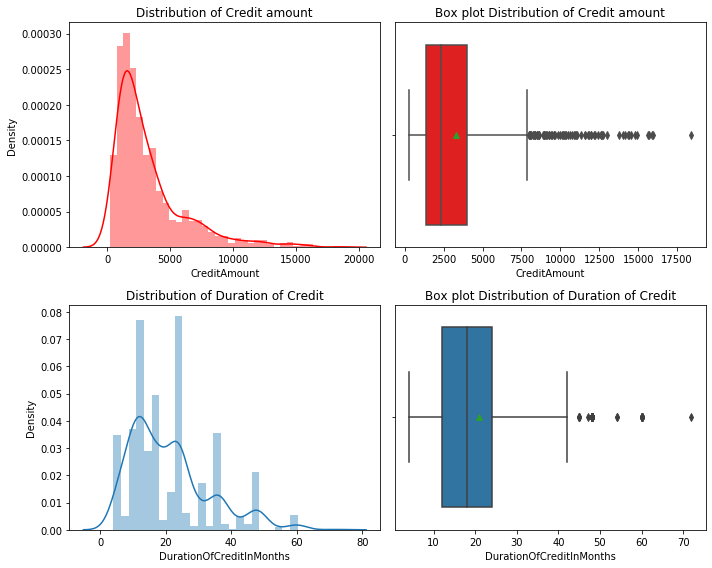

Skewness 1.9406773355861202
Skewness of duration of Credit: 1.087247459620598


In [19]:
#Univariate Analysis:
fig,ax = plt.subplots(2,2,figsize = (10,8))
a = sns.distplot(df_numeric['CreditAmount'],ax=ax[0][0],color='red')
a.set_title("Distribution of Credit amount")
b = sns.boxplot(df_numeric['CreditAmount'],ax=ax[0][1],showmeans=True,color='red')
b.set_title("Box plot Distribution of Credit amount")
c = sns.distplot(df_numeric['DurationOfCreditInMonths'],ax=ax[1][0])
c.set_title("Distribution of Duration of Credit")
d = sns.boxplot(df_numeric['DurationOfCreditInMonths'],ax=ax[1][1],showmeans=True)
d.set_title("Box plot Distribution of Duration of Credit")
plt.tight_layout()
plt.show()
print("Skewness",df_numeric['CreditAmount'].skew())
print("Skewness of duration of Credit:",df_numeric['DurationOfCreditInMonths'].skew())

In [ ]:
#Observation:
#1. Credit amount is positively skewed with the peak at 2500 indicates about half of the data deals with credit amount of 2500. 
#2. Majorly the credit amount lies below 5000 and there are extreme values above the upper limit around 7500
#3. With respect to Duration, there are multiple peaks - around 1 yr, 2 yrs, 3 yrs and 4 yrs.
#4. Most of the duration lies below 24 months (2 yrs period)
#5. There are extreme values above upper limit of 42 months.

In [17]:
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3-Q1
print("No of Outlier records:",df[((df>(Q3 + (3.5*IQR)))).any(axis=1)==True].shape[0])

#Treating the outliers using the IQR method: There are no extreme values below lower whisker. Above the upper whisker, 
#the points are too close to each other and hence extending the limit and removing all the extreme values above Q3 + 3.5IQR

df = df[~((df>(Q3 + (3.5*IQR)))).any(axis=1)]
df = df.reset_index(drop=True)
print("Shape of dataset after outlier treatment:",df.shape)

No of Outlier records: 14
Shape of dataset after outlier treatment: (979, 3)


# 3b. Create creditability dataframe

In [20]:
df_creditability = pd.DataFrame()
df_creditability = pd.get_dummies(df['Creditability'],drop_first=True,prefix='Creditability')
df_creditability.head()

,Creditability_1
0,1
1,1
2,1
3,1
4,1


# 4. Concatenate the above 2 dataframes and give the total of Credibiliity0 and Credibiliity1

In [21]:
req_df = pd.concat([df[['CreditAmount','DurationOfCreditInMonths']],df_creditability],axis=1)
req_df['Creditability_1'].value_counts()

1    689
0    290
Name: Creditability_1, dtype: int64

In [ ]:
#Creditability = 1 has Total of 689 records
#Creditability = 0 has total of 290 records

# 5. Plot Creditworthiness plot for Credibility == 0 and also ==1

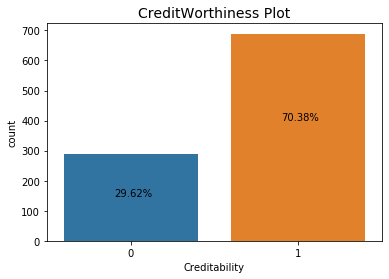

In [22]:
plt.title("CreditWorthiness Plot",fontsize=14)
sns.countplot(req_df['Creditability_1'])
plt.text(-0.1,150,s = str(round((req_df['Creditability_1'].value_counts()[0]/len(req_df))*100,2))+"%")
plt.text(0.9,400,s = str(round((req_df['Creditability_1'].value_counts()[1]/len(req_df))*100,2))+"%")

plt.xlabel("Creditability")
plt.show()

In [ ]:
#The distribution of target variable indicates there is a slight imbalance.

# 6. Prepare input data for the model

In [35]:
data = req_df.drop(['Creditability_1'],axis=1)
target = req_df['Creditability_1']

#Train - Test splitting:
X_train,X_test,Y_train,Y_test = train_test_split(data,target,test_size=0.2,random_state=10,stratify=target)

#Scaling the Train and Test sets using Min Max scaler as the data does not follow normal distribution even after outlier treatment:
X_train = MinMaxScaler().fit_transform(X_train)
X_test = MinMaxScaler().fit_transform(X_test)

print("X_train shape:",X_train.shape)
print("X_test shape:",X_test.shape)
print("Y_train shape:",Y_train.shape)
print("Y_test shape:",Y_test.shape)

X_train shape: (783, 2)
X_test shape: (196, 2)
Y_train shape: (783,)
Y_test shape: (196,)


# 7. Fit logistic regression model

In [37]:
model = LogisticRegression().fit(X_train,Y_train)
Y_pred = model.predict(X_test)
Y_pred_prob = model.predict_proba(X_test)

# 8. Test accuracy calculation

In [47]:
print(classification_report(Y_test,Y_pred))
print("Accuracy of Test set:",accuracy_score(Y_test,Y_pred))
print("\nF1 score of Test set:",f1_score(Y_test,Y_pred))

              precision    recall  f1-score   support

           0       0.73      0.19      0.30        58
           1       0.74      0.97      0.84       138

    accuracy                           0.74       196
   macro avg       0.74      0.58      0.57       196
weighted avg       0.74      0.74      0.68       196

Accuracy of Test set: 0.7397959183673469

F1 score of Test set: 0.8401253918495298


# 9. Build a confusion matrix

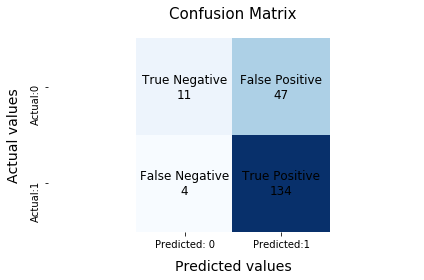

In [45]:
cm = confusion_matrix(Y_test,Y_pred)
conf_matrix = pd.DataFrame(data=cm,columns = ['Predicted: 0','Predicted:1'],index=['Actual:0','Actual:1'])
tags = ['True Negative','False Positive','False Negative','True Positive']
tag_values = [str(value) for value in cm.flatten()]
labels = [f'{i}\n{j}' for i, j in zip(tags,tag_values)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(conf_matrix, annot = labels, cmap = 'Blues',fmt='',annot_kws = {'fontsize':12,'color':'black'},cbar=False)
plt.title ("Confusion Matrix", fontdict = {'size':15},pad=20)
plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
plt.ylabel("Actual values" , fontdict = {'size':14}, labelpad = 10)
plt.axis('equal')
plt.tight_layout()
plt.show()

# 10.  Predicted Probability distribution Plots for Defaults and Non Defaults

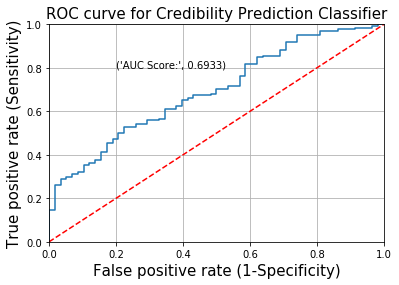

In [50]:
fpr,tpr,thresholds = roc_curve(Y_test,Y_pred_prob[:,1])
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.plot([0, 1], [0, 1],'r--')
plt.title('ROC curve for Credibility Prediction Classifier', fontsize = 15)
plt.xlabel('False positive rate (1-Specificity)', fontsize = 15)
plt.ylabel('True positive rate (Sensitivity)', fontsize = 15)
plt.text(x = 0.2, y = 0.8, s = ('AUC Score:',round(roc_auc_score(Y_test, Y_pred_prob[:,1]),4)))
plt.grid(True)

In [ ]:
#From the AUC score we can understand, there is definitely scope for improvement by tuning the logistic regression model built.

In [66]:
t = pd.DataFrame([np.array(Y_test),Y_pred,Y_pred_prob[:,1]]).T
t.columns = ['Actual','Predicted','Predicted_Probability']
t.head()

,Actual,Predicted,Predicted_Probability
0,1.0,1.0,0.659333
1,1.0,1.0,0.772313
2,1.0,1.0,0.754785
3,1.0,1.0,0.748062
4,0.0,1.0,0.754003


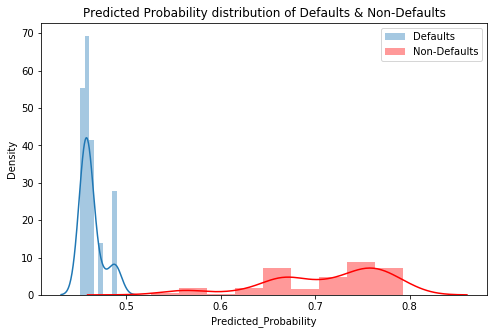

In [87]:
plt.figure(figsize=(8,5))
sns.distplot(t[t['Predicted']==0]['Predicted_Probability'],label=['Defaults'])
sns.distplot(t[t['Predicted']==1]['Predicted_Probability'],color='red',label=['Non-Defaults'])
plt.legend()
plt.title("Predicted Probability distribution of Defaults & Non-Defaults")
plt.show()

In [ ]:
#We can see that when the predicted probability is greater than approx 0.55, it is classified as non defaults. The overall in predicted probability distribution implies the errors

Here we have built a logistic regression model that predicts the credit worthiness 1- worthy and Non-defaults and 0 - Not worthy and Defaults with 74% accuracy and F1 score of 84%. Since the dataset is slightly imbalanced F1 score could be taken as evaluation metric deciding the model performance.
Definitely this model could be fine tuned in future analysis ans also Boosting techniques could be employed 